In [2]:
from collections import defaultdict
from datetime import datetime
from functools import total_ordering
from math import erf

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook

In [3]:
years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/years.csv")
team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_years.csv")
events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/events.csv")
matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/matches.csv")
team_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_matches.csv")

year_team_matches_df = team_matches_df[team_matches_df.year == 2022]

In [4]:
SQRT2 = 2 ** 0.5

correlation = 0.0

@total_ordering
class Normal:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def __add__(self, other):
        return Normal(mu=self.mu + other.mu, sigma=(self.sigma ** 2 + other.sigma ** 2 + 2 * correlation * self.sigma * other.sigma) ** 0.5)
    
    def __sub__(self, other):
        return Normal(mu=self.mu - other.mu, sigma=(self.sigma ** 2 + other.sigma ** 2 + 2 * correlation * self.sigma * other.sigma) ** 0.5)
    
    def __rmul__(self, other):
        return Normal(mu=other * self.mu, sigma=other * self.sigma)
    
    def __lt__(self, other):
        return self.mu < other.mu
    
    def win_prob(self):
        return 0.5 - 0.5 * erf(-self.mu / (self.sigma * SQRT2))
    
    def __repr__(self):
        return "Normal (" + str(round(self.mu, 4)) + ", " + str(round(self.sigma, 4)) + ")"
    
    
class NormalDistrib:
    def mean(self):
        raise NotImplementedError
        
    def sd_mean(self):
        raise NotImplementedError
        
    def sd_obs(self):
        raise NotImplementedError
        
    def sd_total(self):
        return (self.sd_mean() ** 2 + self.sd_obs() ** 2) ** 0.5
    
    def mean_distrib(self):
        return Normal(self.mean(), self.sd_mean())
    
    def obs_distrib(self):
        return Normal(self.mean(), self.sd_total())
    
    def __repr__(self):
        return "(" + \
            str(round(self.mean(), 4)) + ", " + \
            str(round(self.sd_mean(), 4)) + ", " + \
            str(round(self.sd_obs(), 4)) + ", " + \
            str(round(self.sd_total(), 4)) + ")"

In [5]:
class History:
    def __init__(self, *args, **kwargs):
        self._history = []
        
    def history(self, name):
        return [x[name] for x in self._history]
    
    def mean(self):
        raise NotImplementedError
        
    def sd_mean(self):
        raise NotImplementedError
        
    def sd_obs(self):
        raise NotImplementedError
        
    def sd_total(self):
        raise NotImplementedError
        
    def record(self, obs):
        self._history.append({
            "x": len(self._history),
            "obs": obs,
            "mean": self.mean(),
            "sd_mean": self.sd_mean(),
            "sd_obs": self.sd_obs(),
            "sd_total": self.sd_total(),
        })
        
    @staticmethod
    def plot_history(objs):
        fig, ax = plt.subplots(figsize=(9, 6))
        colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
        for color, obj in zip(colors, objs):
            x = obj.history("x")
            scaled_x = [x_i / (len(x) - 1) for x_i in x]
            ax.scatter(scaled_x, obj.history("obs"), label="Observations")
            ax.plot(scaled_x, obj.history("mean"), label="Mean")
            ax.fill_between(
                scaled_x, 
                [x - 2 * y for x, y in zip(obj.history("mean"), obj.history("sd_mean"))], 
                [x + 2 * y for x, y in zip(obj.history("mean"), obj.history("sd_mean"))],
                color=color, 
                alpha=0.4, 
                label="Mean CI"
            )

            """
            ax.fill_between(
                scaled_x, 
                [x - 2 * y for x, y in zip(obj.history("mean"), obj.history("sd_total"))], 
                [x + 2 * y for x, y in zip(obj.history("mean"), obj.history("sd_total"))],
                color=color, 
                alpha=0.2, 
                label="Obs CI"
            )
            """
            
        ax.legend()
        ax.grid()
        fig.show()
        
    
    def max_mean(self):
        return max([0] + self.history("mean"))
    
    def end_mean(self):
        return sum(self.history("mean")[-5:]) / 5

In [6]:
SD = 0.30


class Rating(NormalDistrib, History):
    def __init__(self, prior_n=0, prior_mean=0):
        super().__init__(self, prior_n=0, prior_mean=0)
        self.mu = prior_mean
        self.n = prior_n
        
        self.streaks = [0, 0]
        
    def add(self, x):
        x = max(x, 0)
        self.record(x)
        
        self.mu = (self.mu * self.n + x) / (self.n + 1)
        
        mean, sd = self.mean(), self.sd_total()
        z_score = abs(mean - x) / sd
        if z_score > 1.5:
            self.n -= round(2 * z_score) / 2
            
        self.streaks[0] = self.streaks[0] + 1 if x > mean else 0
        self.streaks[1] = self.streaks[1] + 1 if x < mean else 0
        long_streak = max(self.streaks)
        if long_streak > 1:
            self.n -= long_streak / 2
        
        self.n = min(3, max(1, self.n + 0.5))
        
    def mean(self):
        return self.mu
    
    def sd_mean(self):
        return self.sd_obs() / (self.n) ** 0.5
    
    def sd_obs(self):
        return max(self.mu * SD, 0.01)
    
    def __repr__(self):
        return "Rating " + super().__repr__()

In [7]:
class AbstractTeam(NormalDistrib, History):
    def __init__(self):
        super().__init__()
        
    def mean(self):
        raise NotImplementedError
        
    def sd_mean(self):
        raise NotImplementedError
    
    def sd_obs(self):
        raise NotImplementedError
        
    def add(self, x):
        raise NotImplementedError
        
        
class SimpleTeam(AbstractTeam):
    def __init__(self, prior_n=0, prior_mean=0):
        super().__init__()
        self.rating = Rating(prior_n, prior_mean)
        
    def mean(self):
        return self.rating.mean()
    
    def sd_mean(self):
        return self.rating.sd_mean()
    
    def sd_obs(self):
        return self.rating.sd_obs()
    
    def add(self, x):
        self.record(x)
        self.rating.add(x)
        
    def decay(self):
        self.rating.decay()
        
    def __repr__(self):
        return "Simple Team " + super().__repr__()
    

class FullTeam(AbstractTeam):
    def __init__(self, prior_n=0, prior_mean=0):
        super().__init__()
        self.auto = Rating(prior_n, prior_mean / 3)
        self.teleop = Rating(prior_n, prior_mean / 3)
        self.endgame = Rating(prior_n, prior_mean / 3)
        
    def mean(self):
        return self.auto.mean() + self.teleop.mean() + self.endgame.mean()
    
    def sd_mean(self):
        # assumes fully correlated
        return self.auto.sd_mean() + self.teleop.sd_mean() + self.endgame.sd_mean()
    
    def sd_obs(self):
        # assume fully correlated
        return self.auto.sd_obs() + self.teleop.sd_obs() + self.endgame.sd_obs()
    
    def add(self, x):
        self.record(sum(x))
        self.auto.add(x[0])
        self.teleop.add(x[1])
        self.endgame.add(x[2])
        
    def decay(self):
        self.auto.decay()
        self.teleop.decay()
        self.endgame.decay()
        
    def __repr__(self):
        return "Full Team " + super().__repr__()

In [8]:
event_matches_df = matches_df[(matches_df.year == 2022) & (matches_df.comp_level == "qm") & (matches_df.status == "Completed")].sort_values(by=["time"])

display(event_matches_df)

,key,year,event,comp_level,set_number,match_number,status,red,red_elo_sum,red_opr_sum,...,blue_teleop_1,blue_teleop_2,blue_1,blue_2,blue_teleop,blue_endgame,blue_no_fouls,blue_fouls,blue_rp_1,blue_rp_2
154345,2022nhgrs_qm1,2022,2022nhgrs,qm,1,1,Completed,"7913,131,467",4617,29.69,...,2.0,0.0,4.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0
151040,2022miket_qm1,2022,2022miket,qm,1,1,Completed,"6067,1506,6091",4705,42.20,...,11.0,0.0,13.0,0.0,11.0,6.0,23.0,0.0,0.0,0.0
150436,2022midet_qm1,2022,2022midet,qm,1,1,Completed,"5090,2224,3414",4591,43.95,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
147382,2022flwp_qm1,2022,2022flwp,qm,1,1,Completed,"59,744,1523",4853,66.27,...,1.0,0.0,5.0,0.0,1.0,0.0,9.0,0.0,0.0,0.0
147393,2022flwp_qm2,2022,2022flwp,qm,1,2,Completed,"5410,7652,3627",4427,44.91,...,0.0,0.0,6.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145947,2022carv_qm125,2022,2022carv,qm,1,125,Completed,"1700,870,3654",4952,85.25,...,35.0,0.0,55.0,0.0,35.0,0.0,61.0,0.0,1.0,0.0
157580,2022tur_qm123,2022,2022tur,qm,1,123,Completed,"5484,5985,2539",4947,81.38,...,41.0,0.0,53.0,0.0,41.0,10.0,69.0,4.0,1.0,0.0
157581,2022tur_qm124,2022,2022tur,qm,1,124,Completed,"3792,3061,1391",5122,116.21,...,82.0,0.0,114.0,0.0,82.0,34.0,154.0,4.0,1.0,1.0
157582,2022tur_qm125,2022,2022tur,qm,1,125,Completed,"8006,4003,649",4983,99.21,...,42.0,0.0,58.0,0.0,42.0,20.0,84.0,0.0,1.0,1.0


In [9]:
# TODO: apply nonlinearity, weighted teams, defense component
# TODO: investigate dampening before event
# TODO: compare Elo vs Rating graphs on top of each other, does Elo just update slower??

In [10]:
data = []
new_data = []

mean = 13.8
n = 1
simple_teams = defaultdict(lambda: SimpleTeam(prior_n=n, prior_mean=mean))
full_teams = defaultdict(lambda: FullTeam(prior_n=n, prior_mean=mean))
for _, t in team_years_df[(team_years_df.year == 2022)].iterrows():
    team, opr = t.team, t.opr_start
    simple_teams[team] = SimpleTeam(prior_n=n, prior_mean=opr)
    full_teams[team] = FullTeam(prior_n=n, prior_mean=opr)

count, acc, mse = 0, 0, 0
event_count, event_acc, event_mse = 0, 0, 0
for _, match in event_matches_df.iterrows():
    red_teams = [int(x) for x in match.red.split(",")]
    blue_teams = [int(x) for x in match.blue.split(",")]
    
    red_distrib = sum([simple_teams[t].obs_distrib() for t in red_teams], Normal(0, 0))
    red_total_distrib = sum([full_teams[t].obs_distrib() for t in red_teams], Normal(0, 0))
    
    red_means = [full_teams[t].mean() for t in red_teams]
    red_sd = sum([3.44 + 0.086 * m for m in red_means])
    blue_means = [full_teams[t].mean() for t in blue_teams]
    blue_sd = sum([3.44 + 0.086 * m for m in blue_means])
    mean = sum(red_means) - sum(blue_means)
    sd = (red_sd ** 2 + blue_sd ** 2 - 0.1 * red_sd * blue_sd) ** 0.5
    win_prob = Normal(mean, sd).win_prob()
    
    blue_distrib = sum([simple_teams[t].obs_distrib() for t in blue_teams], Normal(0, 0))
    blue_total_distrib = sum([full_teams[t].obs_distrib() for t in blue_teams], Normal(0, 0))
    
    
    # win_prob = (red_total_distrib - blue_total_distrib).win_prob()
    # win_prob = (win_prob + match.elo_win_prob) / 2
    
    data.append({
        "red_pred": red_total_distrib.mu,
        "red_actual": match.red_no_fouls,
        "blue_pred": blue_total_distrib.mu,
        "blue_actual": match.blue_no_fouls,
        "win_pred": win_prob,
        "win_actual": match.red_score > match.blue_score,
    })
    
    new_data.append({
        "red_1": full_teams[red_teams[0]].mean(),
        "red_2": full_teams[red_teams[1]].mean(),
        "red_3": full_teams[red_teams[2]].mean(),
        "red_actual": match.red_no_fouls,
        "blue_1": full_teams[blue_teams[0]].mean(),
        "blue_2": full_teams[blue_teams[1]].mean(),
        "blue_3": full_teams[blue_teams[2]].mean(),
        "blue_actual": match.blue_no_fouls
    })
    
    mle_weight = 0.2
    for teams, actual in [(red_teams, match.red_no_fouls), (blue_teams, match.blue_no_fouls)]:
        means, sds = [simple_teams[t].mean() for t in teams], [simple_teams[t].sd_obs() for t in teams]
        pred, variance = sum(means), sum([sd ** 2 for sd in sds])
        for team, mean, sd in zip(teams, means, sds):
            contrib1 = mean + 1 / 3 * (actual - pred)
            contrib2 = mean + sd ** 2 / variance * (actual - pred)
            simple_teams[team].add((1 - mle_weight) * contrib1 + mle_weight * contrib2)
    
    contribs = defaultdict(list)
    for teams, get_mean, get_sd, actual in [
        (red_teams, lambda t: t.auto.mean(), lambda t: t.auto.sd_obs(), match.red_auto),
        (red_teams, lambda t: t.teleop.mean(), lambda t: t.teleop.sd_obs(), match.red_teleop),
        (red_teams, lambda t: t.endgame.mean(), lambda t: t.endgame.sd_obs(), match.red_endgame),
        (blue_teams, lambda t: t.auto.mean(), lambda t: t.auto.sd_obs(), match.blue_auto),
        (blue_teams, lambda t: t.teleop.mean(), lambda t: t.teleop.sd_obs(), match.blue_teleop),
        (blue_teams, lambda t: t.endgame.mean(), lambda t: t.endgame.sd_obs(), match.blue_endgame),
    ]:
        means, sds = [get_mean(full_teams[t]) for t in teams], [get_sd(full_teams[t]) for t in teams]
        pred, variance = sum(means), sum([sd ** 2 for sd in sds])
        for team, mean, sd in zip(teams, means, sds):
            contrib1 = mean + 1 / 3 * (actual - pred)
            contrib2 = mean + sd ** 2 / variance * (actual - pred)
            contribs[team].append((1 - mle_weight) * contrib1 + mle_weight * contrib2)
            
    for t in contribs:
        full_teams[t].add(contribs[t])
        
    if not match.playoff:
        count += 1
        acc += (win_prob > 0.5 and match.red_score > match.blue_score) or (win_prob < 0.5 and match.red_score < match.blue_score)
        mse += (1 - win_prob) ** 2 if match.red_score > match.blue_score else win_prob ** 2  
    
    if match.event in ["2022carv", "2022gal", "2022hop", "2022new", "2022roe", "2022tur"] and not match.playoff:
        # print(match.key)
        # print(red_teams, blue_teams)
        # print(red_total_distrib, blue_total_distrib, win_prob)
        # print(match.red_score, match.blue_score)
        # print()
        event_count += 1
        event_acc += (win_prob > 0.5 and match.red_score > match.blue_score) or (win_prob < 0.5 and match.red_score < match.blue_score)
        event_mse += (1 - win_prob) ** 2 if match.red_score > match.blue_score else win_prob ** 2  
    
print(count, acc / count, mse / count)
print(event_count, event_acc / event_count, event_mse / event_count)

12048 0.766019256308101 0.15313690624876575
756 0.7592592592592593 0.15096063353220848


In [11]:
elo_count, elo_acc, elo_mse = 0, 0, 0
event_elo_count, event_elo_acc, event_elo_mse = 0, 0, 0
for _, match in event_matches_df.iterrows():
    elo_win_prob = match.elo_win_prob
    elo_count += 1
    elo_acc += (elo_win_prob > 0.5 and match.red_score > match.blue_score) or (elo_win_prob < 0.5 and match.red_score < match.blue_score)
    elo_mse += (1 - elo_win_prob) ** 2 if match.red_score > match.blue_score else elo_win_prob ** 2
    
    if match.event in ["2022carv", "2022gal", "2022hop", "2022new", "2022roe", "2022tur"] and not match.playoff:
        event_elo_count += 1
        event_elo_acc += (elo_win_prob > 0.5 and match.red_score > match.blue_score) or (elo_win_prob < 0.5 and match.red_score < match.blue_score)
        event_elo_mse += (1 - elo_win_prob) ** 2 if match.red_score > match.blue_score else elo_win_prob ** 2
    
    
print(elo_count, elo_acc / elo_count, elo_mse / elo_count)
print(event_elo_count, event_elo_acc / event_elo_count, event_elo_mse / event_elo_count)

12048 0.7478419654714475 0.16523318930942865
756 0.783068783068783 0.14620109343915336


62.499272298124126 62.74125412701496


<IPython.core.display.Javascript object>


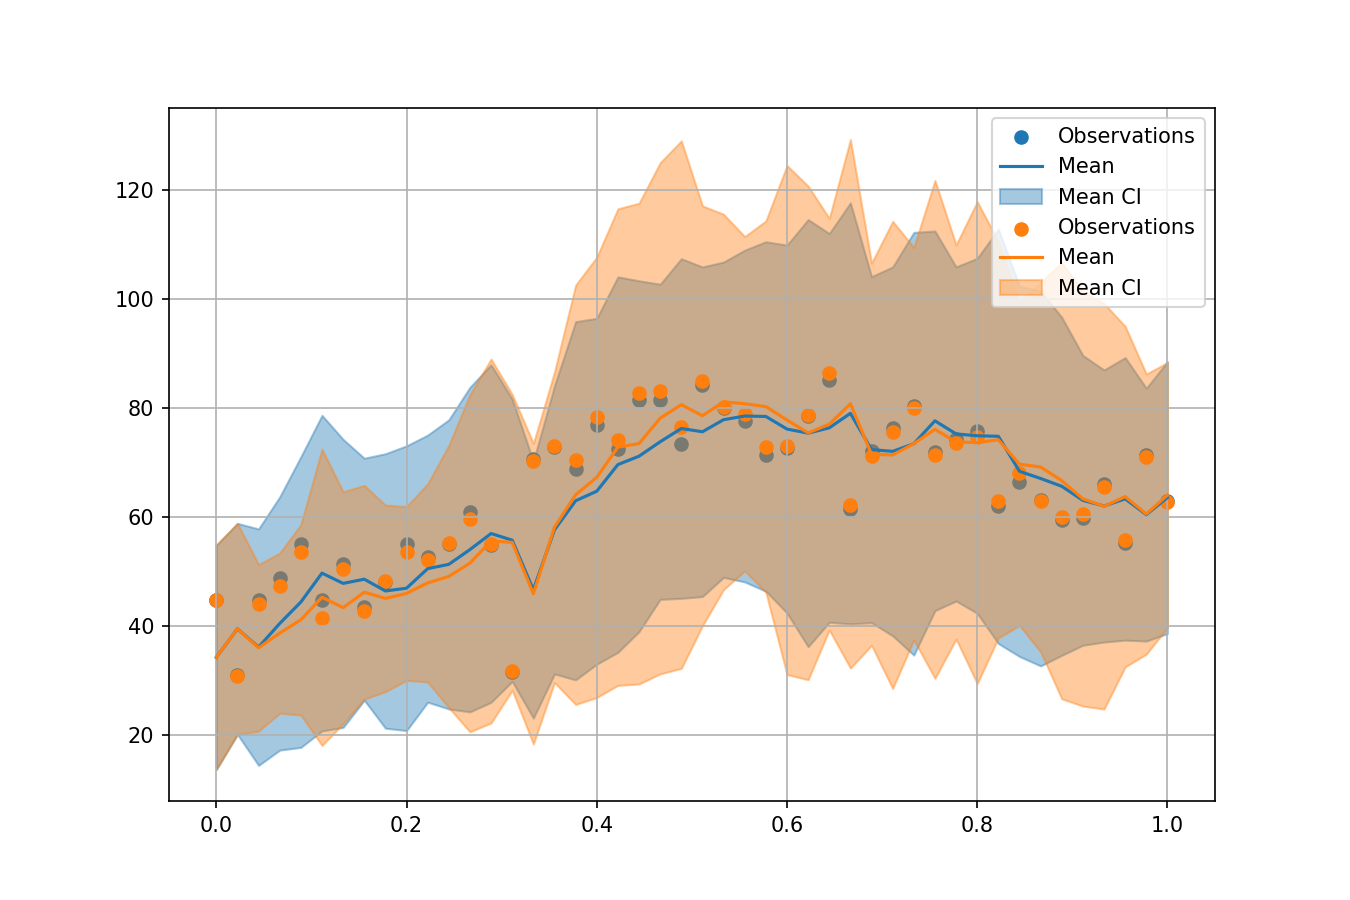

In [12]:
t = 1690
print(full_teams[t].end_mean(), simple_teams[t].end_mean())
History.plot_history([full_teams[t], simple_teams[t]])

<IPython.core.display.Javascript object>


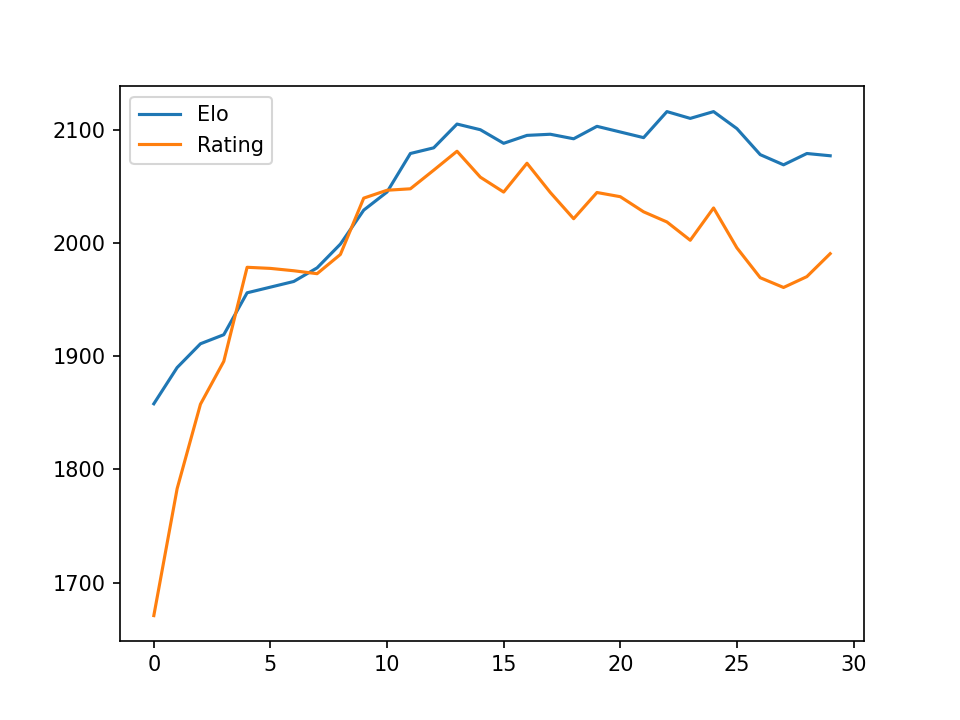

In [13]:
team = 254

fig, ax = plt.subplots()
elo = year_team_matches_df[(year_team_matches_df.team == team) & (year_team_matches_df.playoff == False)].sort_values(by=["time"]).elo
x = [i for i in range(elo.shape[0])]
rating = full_teams[team].history("mean")
ax.plot(x, elo, label="Elo")
ax.plot(x, [1361 + 9.25 * r for r in rating], color="tab:orange", label="Rating")
ax.legend()
fig.show()

In [14]:
final_ratings = {}
for t in simple_teams:
    final_ratings[t] = full_teams[t].end_mean()
sorted(final_ratings.items(), key=lambda x:-x[1])[:10]

[(1678, 80.52643942538336),
 (1323, 66.6404078216859),
 (254, 66.62820597812531),
 (67, 66.36878039152228),
 (1577, 64.98761773835281),
 (1690, 62.499272298124126),
 (118, 62.39719812853588),
 (27, 61.30948218977748),
 (1619, 60.953770850524094),
 (2910, 59.812532611892344)]

<IPython.core.display.Javascript object>


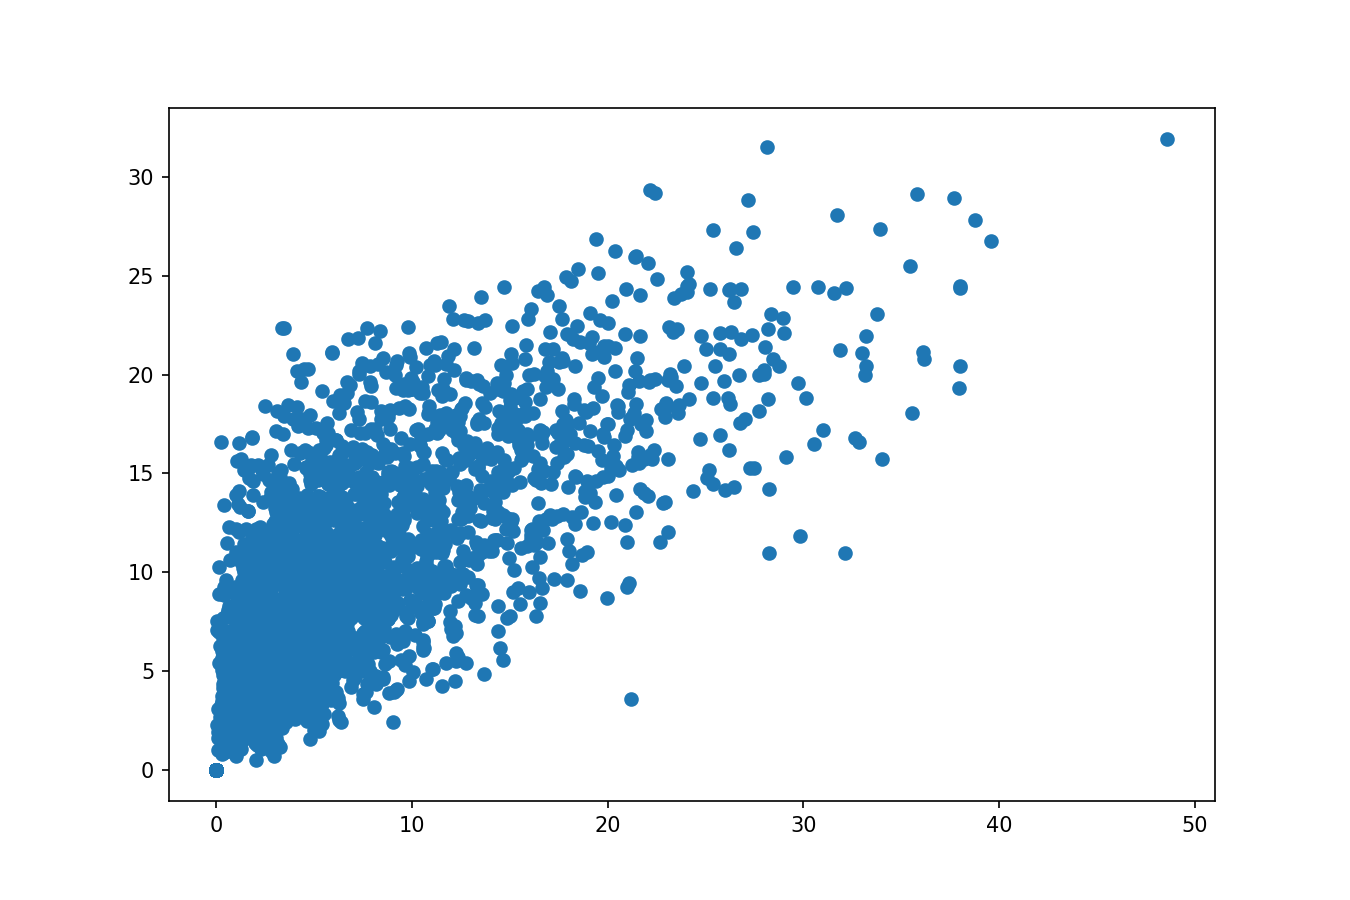

In [15]:
auto_list = [x.auto.end_mean() for x in full_teams.values()]
teleop_list = [x.teleop.end_mean() for x in full_teams.values()]
auto_teleop_list = [x + y for x, y in zip(auto_list, teleop_list)]
endgame_list = [x.endgame.end_mean() for x in full_teams.values()]
auto_endgame_list = [x + y for x, y in zip(auto_list, endgame_list)]
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(teleop_list, auto_endgame_list)
fig.show()

In [16]:
data_df = pd.DataFrame(data)
display(data_df.sort_values(by=["win_pred"]).head(30))

,red_pred,red_actual,blue_pred,blue_actual,win_pred,win_actual
11441,34.861105,31.0,167.673267,120.0,6.868452e-07,False
5848,18.141198,14.0,128.745771,136.0,1.926359e-06,False
6488,28.270647,20.0,139.439832,109.0,4.884932e-06,False
10576,24.376369,26.0,118.735067,77.0,2.876495e-05,False
7607,38.623951,24.0,139.569810,137.0,3.949913e-05,False
11315,56.792546,52.0,166.337221,173.0,5.381677e-05,False
11885,30.929375,54.0,122.257371,153.0,7.033264e-05,False
8134,30.506093,43.0,120.931230,134.0,7.612606e-05,False
10697,25.421926,29.0,109.544723,124.0,1.147998e-04,False
11504,30.082774,8.0,116.735160,125.0,1.171642e-04,False


<IPython.core.display.Javascript object>


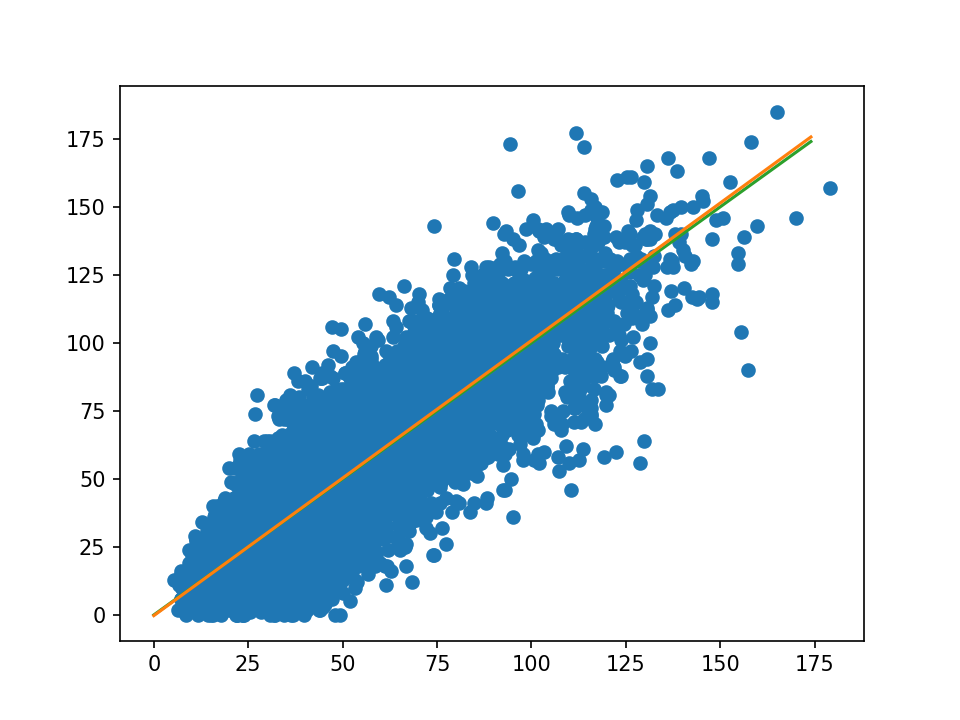

1.0109779918015955 -0.23647942461245727


In [17]:
fig, ax = plt.subplots()
ax.scatter(data_df.red_pred, data_df.red_actual)
m, b = np.polyfit(data_df.red_pred, data_df.red_actual, 1)
print(m, b)
ax.plot([x for x in range(175)], [x for x in range(175)], color="tab:green")
ax.plot([x for x in range(175)], [m * x + b for x in range(175)], color="tab:orange")
fig.show()

<IPython.core.display.Javascript object>


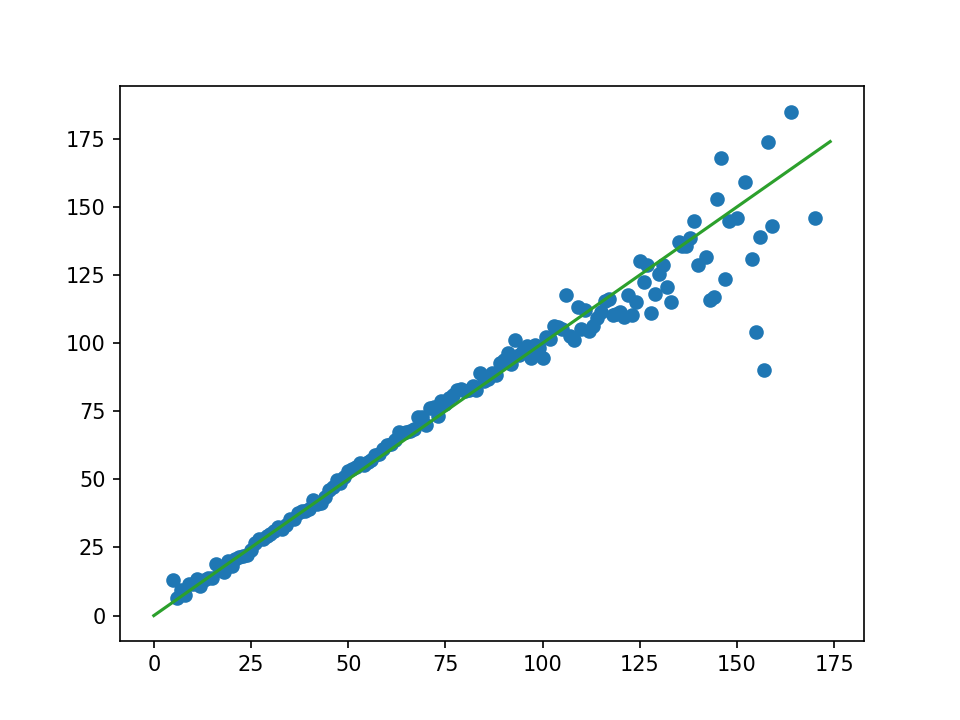

In [18]:
fig, ax = plt.subplots()

x, y = [], []
temp_df = data_df
for i in range(175):
    subset_df = temp_df[(temp_df.red_pred > i) & (temp_df.red_pred < i + 1)]
    actual = subset_df.red_actual.mean()
    x, y = x + [i], y + [actual]
    
x, y = np.array(x), np.array(y)
ax.scatter(x, y)
ax.plot(x, x, color="tab:green")
fig.show()

<IPython.core.display.Javascript object>


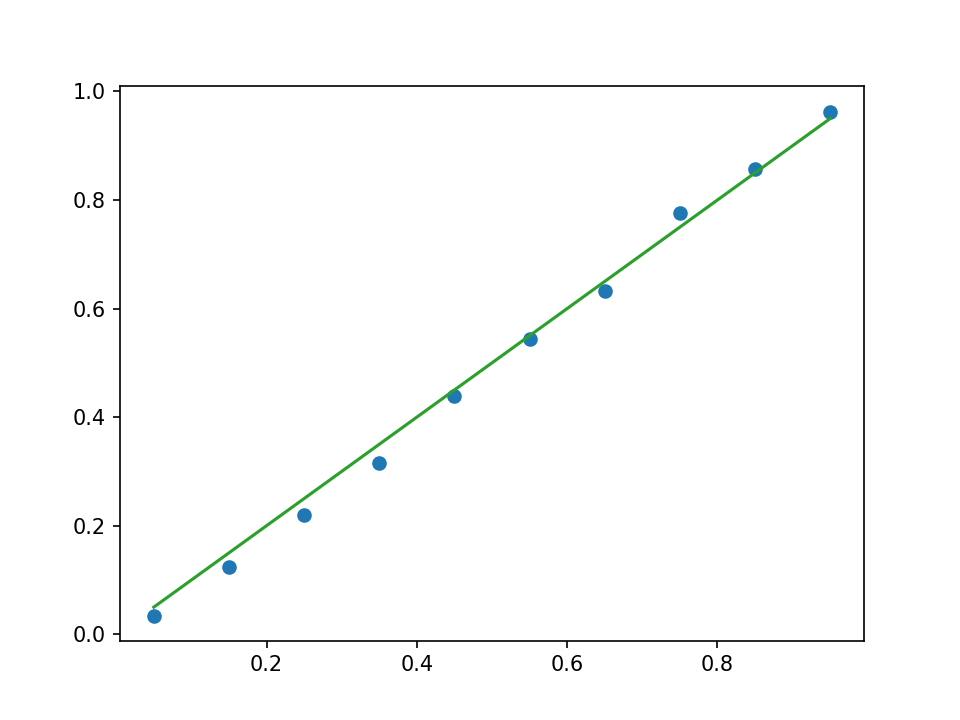

In [19]:
fig, ax = plt.subplots()

x, y = [], []
n = 10
temp_df = data_df
for i in range(n):
    percent = i / n
    subset_df = temp_df[(temp_df.win_pred > percent) & (temp_df.win_pred < percent + 1 / n)]
    actual_percent = subset_df.win_actual.mean()
    x, y = x + [percent + 1 / n /2], y + [actual_percent]
    
x, y = np.array(x), np.array(y)
ax.scatter(x, y)
ax.plot(x, x, color="tab:green")
fig.show()

<IPython.core.display.Javascript object>


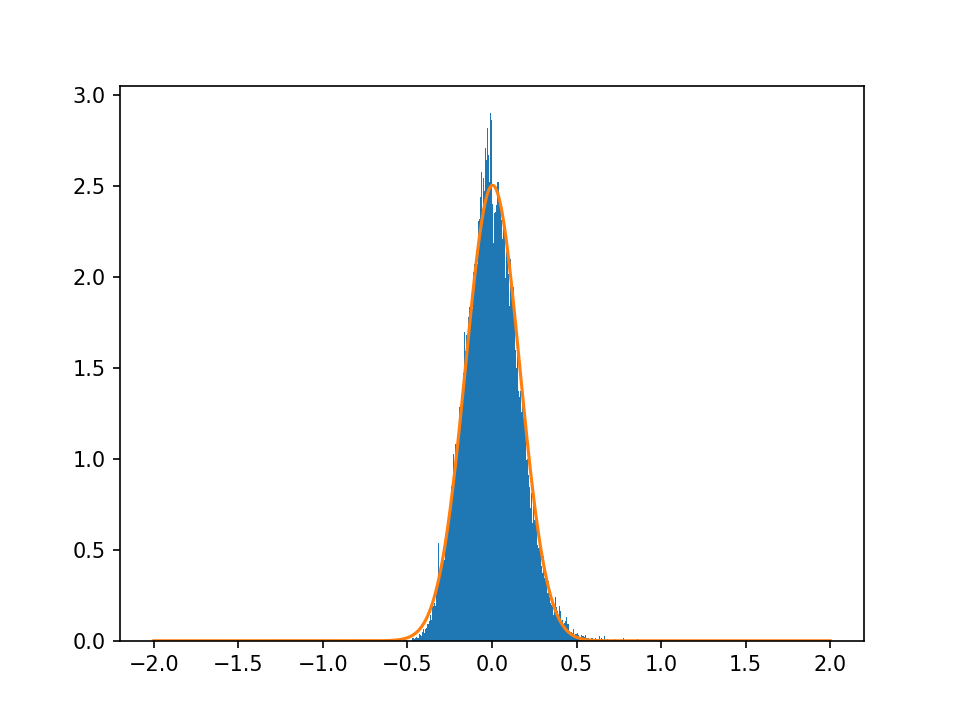

NormalDist(mu=0.0037452603561139632, sigma=0.15936138173891226)
67.29062503075225


In [55]:
from statistics import NormalDist
from scipy.stats import chisquare

distrib = []
for team in full_teams:
    for obs, mean in zip(full_teams[team].endgame.history("obs"), full_teams[team].endgame.history("mean")):
        val = (obs - mean) / (mean + 10)
        
        if abs(val) < 5:
            distrib.append(val)
            
fig, ax = plt.subplots()
y_actual = ax.hist(distrib, bins=500, density=True)
norm = NormalDist.from_samples(distrib)
print(norm)
x = np.linspace(-2, 2, 1000)
y = 1 / np.sqrt(2 * np.pi) / norm.stdev * np.exp(-1/2*((x-norm.mean)/norm.stdev)**2)
ax.plot(x, y)

x_new = np.linspace(-2, 2, 500)
y_pred = 2 * 1 / np.sqrt(2 * np.pi) / norm.stdev * np.exp(-1/2*((x_new-norm.mean)/norm.stdev)**2)
print(np.log(chisquare(y_actual[0], y_pred).statistic))

<IPython.core.display.Javascript object>


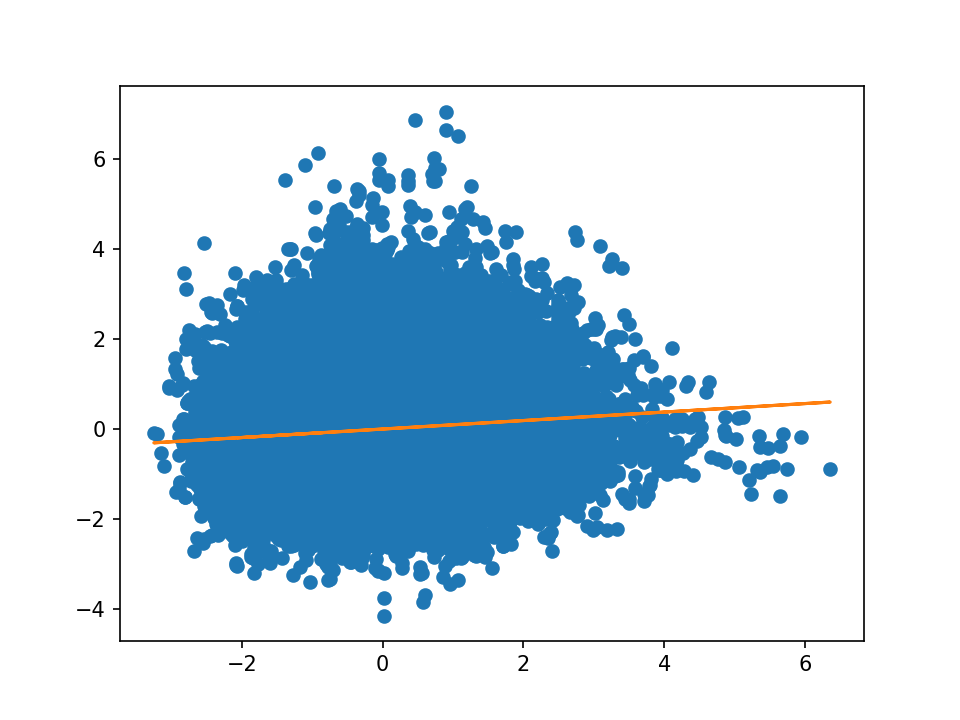

[0.09411557]


In [58]:
# auto sd ~ 1.2 + 0.12 * mean, 0.17 correl with endgame, 0.30 correl with teleop
# teleop sd ~ 2.0 + 0.13 * mean, 0.30 correl with auto, 0.11 correl with endgame
# endgame sd ~ 1.6 + 0.12 * mean, 0.17 correl with auto, 0.11 correl with teleop

from scipy.optimize import curve_fit

def fit_func(x, a):
    # Curve fitting function
    return a * x

xs, ys = [], []
for team in full_teams:
    t = full_teams[team]
    for x, x_pred, y, y_pred in zip(t.endgame.history("obs"), t.endgame.history("mean"), t.teleop.history("obs"), t.teleop.history("mean")):
        xs.append((x - x_pred) / (1.6 + 0.16 * x_pred))
        ys.append((y - y_pred) / (2 + 0.12 * y_pred))
xs = np.array(xs)
ys = np.array(ys)
fig, ax = plt.subplots()
ax.scatter(xs, ys)
params = curve_fit(fit_func, xs, ys)
print(params[0])
ax.plot(xs, params[0][0] * xs, color="tab:orange")
fig.show()

<IPython.core.display.Javascript object>


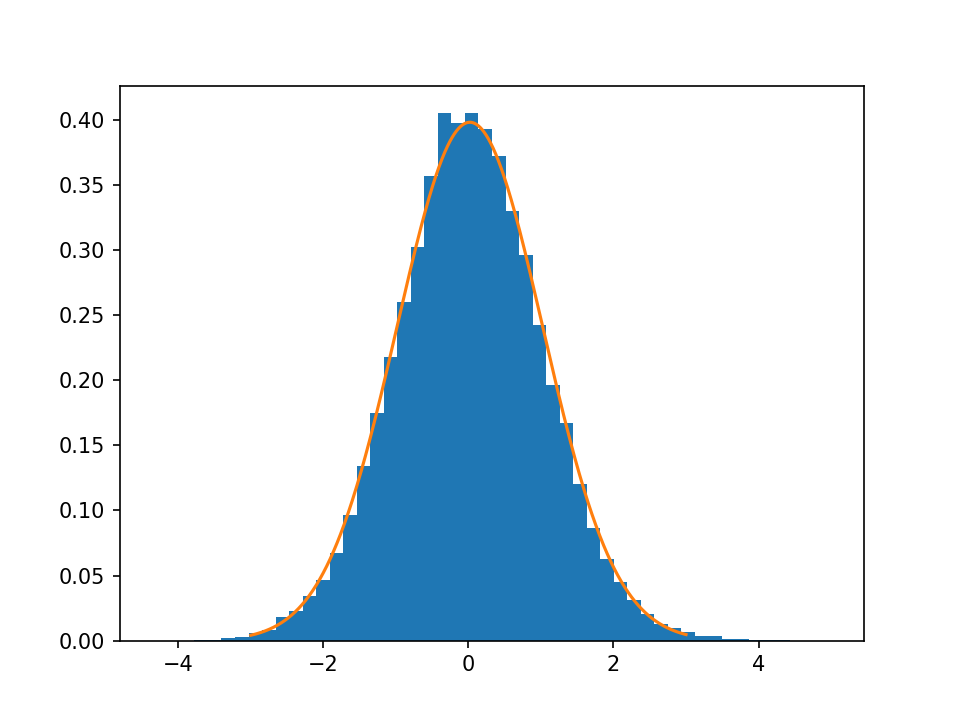

NormalDist(mu=0.019500751918265617, sigma=1.0025257233804965)
0.7928133237119154 0.8569621481185449


<IPython.core.display.Javascript object>


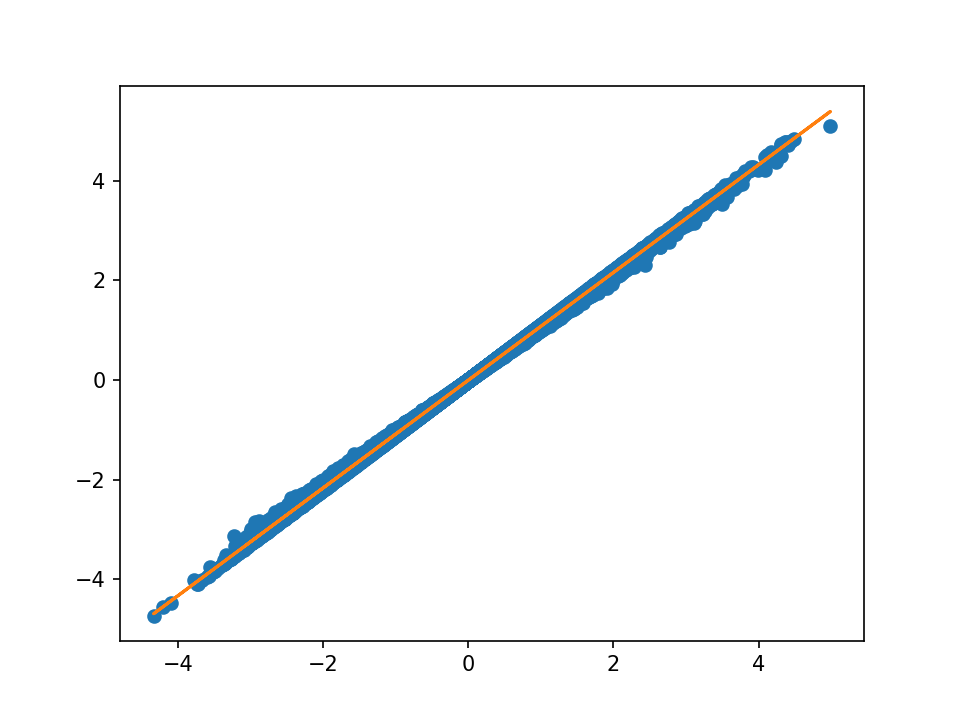

1.0810717756575894 -0.0008793858963838824


In [701]:
distrib = []
sd_x, sd_y = [], []
for team in full_teams:
    t = full_teams[team]
    for obs, auto, teleop, endgame, total in zip(t.history("obs"), t.auto.history("mean"), t.teleop.history("mean"), t.endgame.history("mean"), t.history("mean")):
        sd1 = 3.33 + 0.086 * total
        sd2_a = 1.2 + 0.12 * auto
        sd2_t = 2 + 0.13 * teleop
        sd2_e = 1.6 + 0.12 * endgame
        sd2 = (sd2_a **2 + sd2_t ** 2 + sd2_e ** 2 + 0.17 *sd2_a * sd2_e + 0.30 * sd2_a * sd2_t + 0.11 * sd2_t * sd2_e) ** 0.5
        val = (obs - total) / sd1
        sd_x.append((obs - total) / sd1)
        sd_y.append((obs - total) / sd2)
        
        if abs(val) < 5:
            distrib.append(val)
            
fig, ax = plt.subplots()
y_actual = ax.hist(distrib, bins=50, density=True)
norm = NormalDist.from_samples(distrib)
print(norm)
x = np.linspace(-3, 3, 1000)
y = 1 / np.sqrt(2 * np.pi) / norm.stdev * np.exp(-1/2*((x-norm.mean)/norm.stdev)**2)
ax.plot(x, y)

sd_x, sd_y = np.array(sd_x), np.array(sd_y)
print(np.mean(np.abs(sd_x)), np.mean(np.abs(sd_y)))
m, b = np.polyfit(sd_x, sd_y, 1)
fig, ax = plt.subplots()
ax.scatter(sd_x, sd_y)
ax.plot(sd_x, m * sd_x + b, color="tab:orange")
print(m, b)
fig.show()

<IPython.core.display.Javascript object>


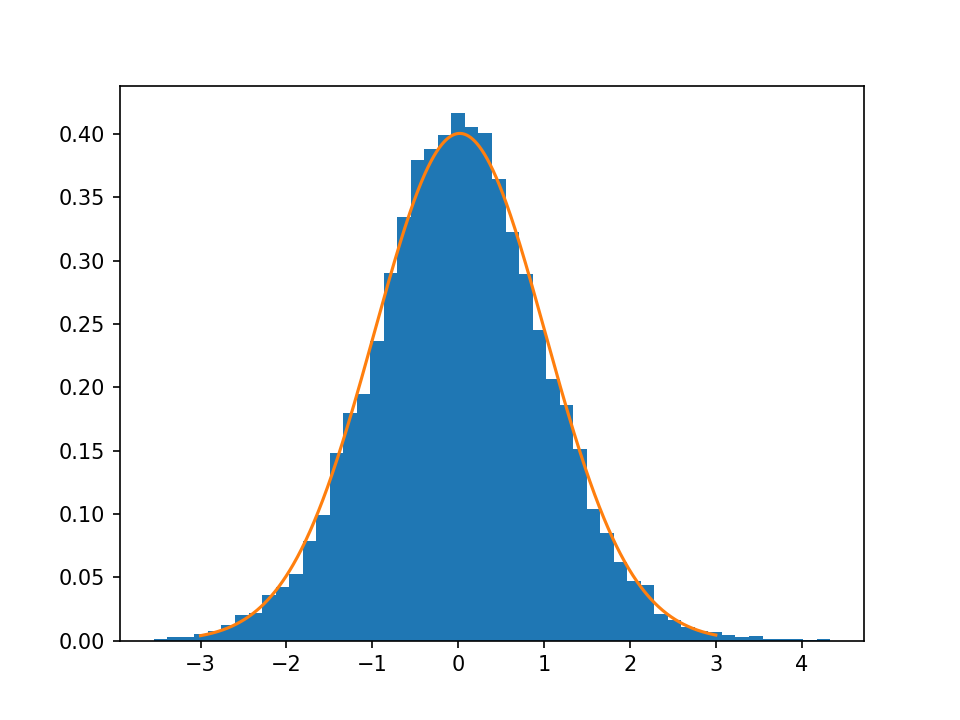

NormalDist(mu=0.018280078634132845, sigma=0.9960256268054896)


In [702]:
distrib = []
new_data_df = pd.DataFrame(new_data)
for _, row in new_data_df.iterrows():
    pred_sum = row.red_1 + row.red_2 + row.red_3
    diff = row.red_actual - pred_sum
    sds = [3.44 + 0.086 * row.red_1, 3.44 + 0.086 * row.red_2, 3.44 + 0.086 * row.red_3]
    correlation = 0.95
    sd = (sds[0] ** 2 + sds[1] ** 2 + sds[2] ** 2 + 2 * correlation * (sds[0] * sds[1] + sds[1] * sds[2] + sds[0] * sds[2])) ** 0.5
    distrib.append(diff / sd)
    
fig, ax = plt.subplots()
ax.hist(distrib, bins=50, density=True)
fig.show()

norm = NormalDist.from_samples(distrib)
print(norm)
x = np.linspace(-3, 3, 1000)
y = 1 / np.sqrt(2 * np.pi) / norm.stdev * np.exp(-1/2*((x-norm.mean)/norm.stdev)**2)
ax.plot(x, y)

<IPython.core.display.Javascript object>


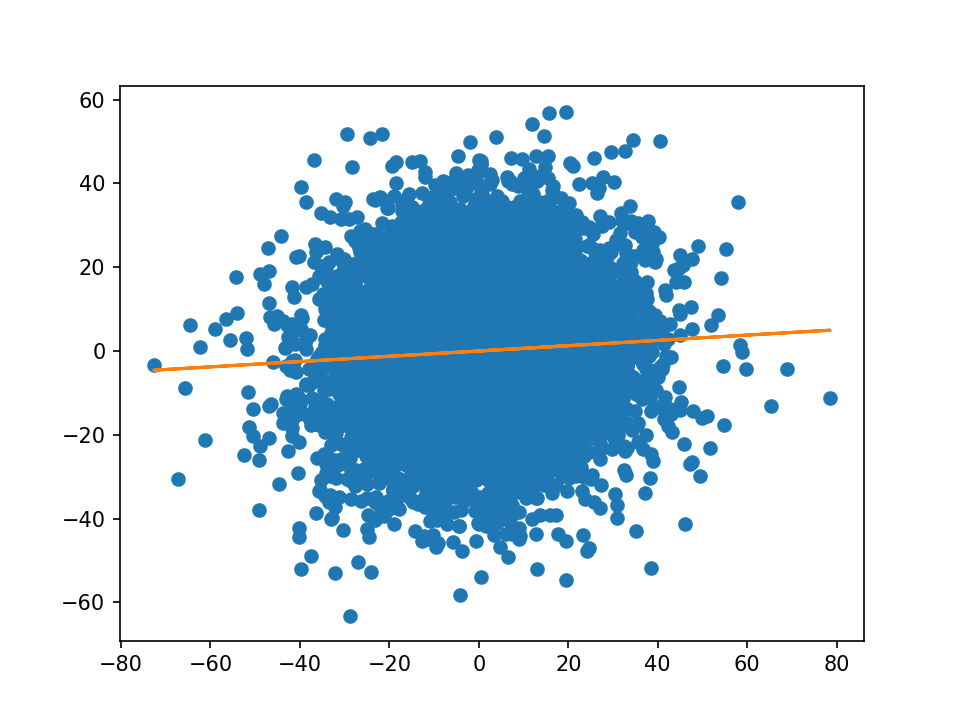

[0.06316736]


In [703]:
from scipy.optimize import curve_fit

def fit_func(x, a):
    # Curve fitting function
    return a * x

xs, ys = [], []
new_data_df = pd.DataFrame(new_data)
for _, row in new_data_df.iterrows():
        red_sd = 10 + 0.086 * (row.red_1 + row.red_2 + row.red_3)
        xs.append((row.red_actual - (row.red_1 + row.red_2 + row.red_3)))
        blue_sd = 10 + 0.086 * (row.blue_1 + row.blue_2 + row.blue_3)
        ys.append((row.blue_actual - (row.blue_1 + row.blue_2 + row.blue_3)))
xs = np.array(xs)
ys = np.array(ys)
fig, ax = plt.subplots()
ax.scatter(xs, ys)
params = curve_fit(fit_func, xs, ys)
print(params[0])
ax.plot(xs, params[0][0] * xs, color="tab:orange")
fig.show()

<IPython.core.display.Javascript object>


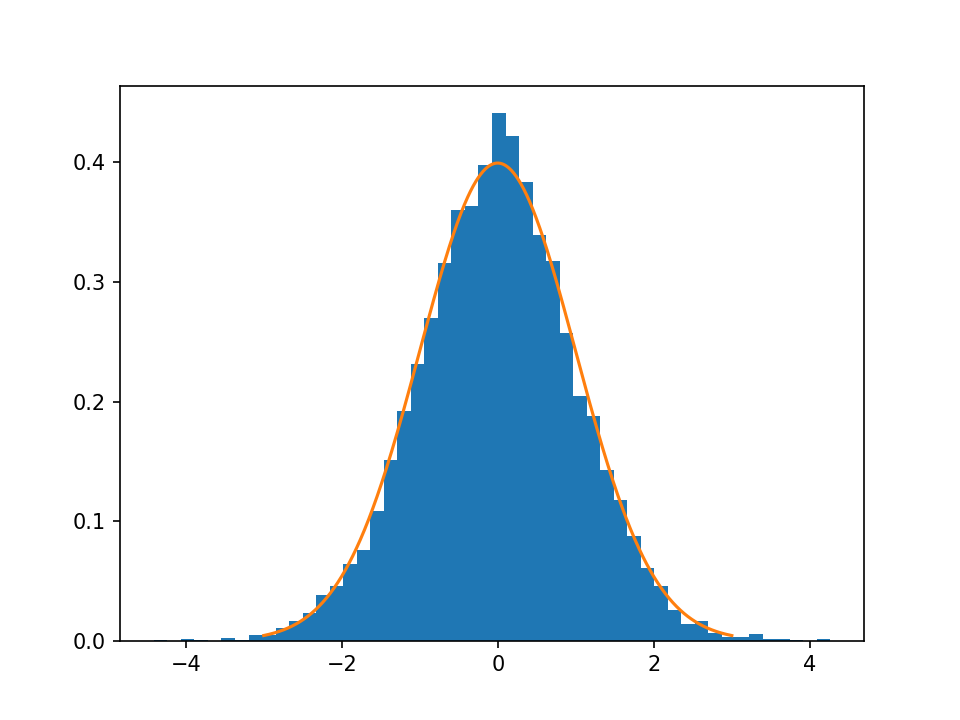

NormalDist(mu=-0.0016911063010765703, sigma=0.9989788890572256)


In [704]:
distrib = []
new_data_df = pd.DataFrame(new_data)
for _, row in new_data_df.iterrows():
    pred_sum = row.red_1 + row.red_2 + row.red_3 - row.blue_1 - row.blue_2 - row.blue_3
    diff = row.red_actual - row.blue_actual - pred_sum
    red_sd = 10.3 + 0.086 * (row.red_1 + row.red_2 + row.red_3)
    blue_sd = 10.3 + 0.086 * (row.blue_1 + row.blue_2 + row.blue_3)
    correlation = -0.10
    sd = (red_sd ** 2 + blue_sd ** 2 + 2 * correlation * red_sd * blue_sd) ** 0.5
    distrib.append(diff / sd)
    
fig, ax = plt.subplots()
ax.hist(distrib, bins=50, density=True)
fig.show()

norm = NormalDist.from_samples(distrib)
print(norm)
x = np.linspace(-3, 3, 1000)
y = 1 / np.sqrt(2 * np.pi) / norm.stdev * np.exp(-1/2*((x-norm.mean)/norm.stdev)**2)
ax.plot(x, y)